In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import sys
sys.path.append("../subjective-fits/")
import seaborn as sns
figsize(8,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

# Comparing approaches to subjective probability and statistics

We illustrate various approaches to statistics based on subjective probability. Our test case is the estimation of the mean of a one-dimensional Gaussian. We will demonstrate each approach to subjective probability using one point estimate and one "uncertainty" interval. We will also comment on the mathematical derivation as well as the interpretation of these two outputs differ for each approach.

The setting is $x_1,\dots,x_N\sim\mathcal{N}(\mu,\sigma^2)$, with $\sigma^2$ known. The statistician's goal is to infer $\mu$, and state his uncertainty about his estimate. 

In [3]:
def generateData(N, mu, sigma2, tag="well-specified"):
    if tag=="well-specified":
        return mu+np.sqrt(sigma2)*npr.randn(N)

In [69]:
npr.seed(1)
muTrue = 1
sigma2True = 1
alpha = .05
gamma = 0.5 # importance of the length of the interval vs. the interval containing the true value
N = 10
x = generateData(N, muTrue, sigma2True)

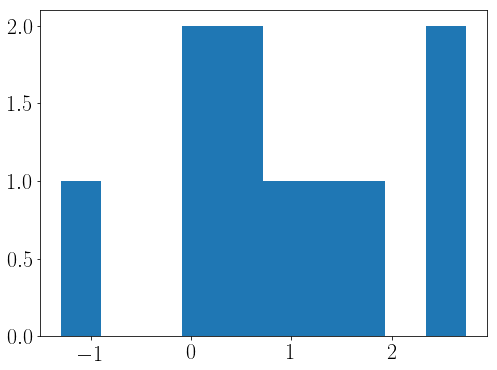

In [70]:
plt.hist(x)
plt.show()

The dataset is denoted by $\mathcal{D}= \left\lbrace x_1, ..., x_N \right\rbrace$. The corresonding likelihood function is 
$$ L \left( \theta; \mathcal{D} \right)  = \prod_{i=1}^N \frac{1}{\sigma \sqrt{2\pi}}\exp \left( - \frac{\left( \theta - x_i \right)^2}{2 \sigma^2} \right).$$

The maximum likelihood estimate (MLE) of $\mu$ is the sample mean $\bar{x}$.

In [71]:
intervals = {}

## Conjugate Bayes

TODO: Describe here the Bayesian approach, including the cost function

Define the following interval cost function:
$$J \left (\alpha \right) = \gamma \vert I_\alpha\vert + 1_{\theta\notin I_\alpha} $$

The first term penalizes the interval width, i.e. the precision of the piece of information $\mu \in I_\alpha$. The second term penalizes the inability of $I_\alpha$ to contain $\mu$. Finally $\gamma$ is a usual tradeoff hyper that regulates the relative strengths of both terms.

In [72]:
import ConjugateBayes as cb
cb = cb.ConjugateBayes(data=x, sigma2Lhd=sigma2True**2, muPrior=10, sigma2Prior=10)

In [73]:
#Each approaches should be implemented in one class, in a separate python file. Each approach should have the following two methods:
print(cb.estimate()) # yields a point estimate, here the posterior mean
print(cb.interval(1-alpha)) # yields an uncertainty quantification, here a credible interval of posterior mass 1-alpha

0.9929298110830694
(0.3762107036326291, 1.6096489185335097)


Now among centered intervals, I want to pick the one with the best integrated cost 
$$\int \left(\gamma \vert I_\alpha\vert + 1_{\theta\notin I_\alpha}\right) p(\theta\vert x)d\theta = \gamma \vert I_\alpha\vert + \alpha$$

In [74]:
alphas = np.linspace(0.01,.99, 100)
costs_cb = []
for alpha  in alphas:
    # Compute cost for various alphas
    lo, hi = cb.interval(1-alpha)
    costs_cb.append( gamma*(hi-lo) + alpha )

ind = np.argmin(costs_cb) # Find the alpha that minimizes the cost
alphaStar = alphas[ind]
intervals["conjugate Bayes"] = cb.interval(alphaStar)
print("The cost is minimized for alpha=", alphaStar)
print("The interval is then", intervals["conjugate Bayes"])

The cost is minimized for alpha= 0.16838383838383839
The interval is then (0.9260242367945339, 1.059835385371605)


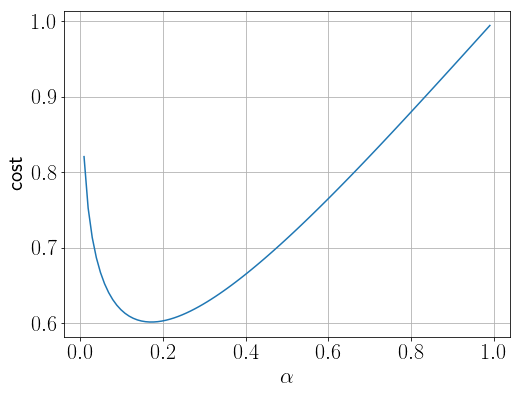

In [75]:
# We can visualize this best alpha
plt.plot(alphas, costs_cb)
plt.xlabel(r"$\alpha$")
plt.ylabel("cost")
plt.grid()
plt.show()

The Bayes action is to report the credible interval with $\alpha$ set to the minizer of this curve!

## Likelihood based Belief Function
In the belief function framework, as well as in other ill-known probabilities frameworks, we work with a pair of functions interpreted as lower and upper bounds of the odds of $\theta$ being $\mu$. The lower bound $bel$ is called **belief function** while the upper bound $pl$ is called **plausibility function**. These functions are set functions, which means that their domain is the set of subsets of $\Theta = \mathbb{R}$. For any subset $A\subset \Theta$, the two functions are related by

$$bel \left( A \right) = 1 - pl \left(A^c\right).$$

Our inference on $\mu$ is represented by the likelihood based belief function. The corresponding plausibility function is defined as 
$$ pl \left( \theta \right) = \frac{L \left( \theta ; \mathcal{D} \right)}{L \left( \bar{x} ; \mathcal{D} \right)}, \forall \theta \in \mathbb{R} \\
pl \left( H \right) = \underset{\theta \in H}{\sup} pl \left( \theta \right), \forall H \subseteq \mathbb{R}
$$

In [76]:
import BaselineBF as bf
bf = bf.BaselineBF(data=x, sigma2Lhd=sigma2True)

In [77]:
print(bf.estimate()) # yields a point estimate, here the MLE
print(bf.interval(.05))

0.9028591091939001
(0.1288135971529102, 1.6769046212348901)


  Now, we are still interested in the same interval cost function $J \left(\alpha \right)$, but we have two non additive measures against which it can be integrated :
  $$ (C)\int J\: dbel = \gamma \vert I_\alpha \vert \text{ (Conservative approach)},\\
  (C)\int J\: dpl = \gamma \vert I_\alpha \vert + \alpha \text{ (Optimistic approach)},$$
  
  where $(C)\int$ is the Choquet integral symbol.

The conservative cost is minimized for alpha= 0.99
The interval is then [0.8580253365364457, 0.9476928818513545]
The optimistic cost is minimized for alpha= 0.16838383838383839
The interval is then [0.3059488724963063, 1.4997693458914938]


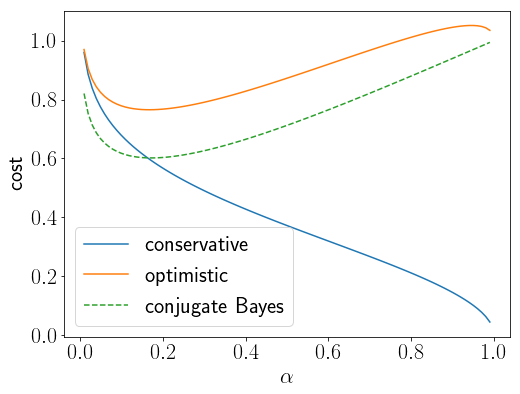

In [78]:
costs_cons = []
costs_optm = []
for alpha  in alphas:
    lo, hi = bf.interval(alpha)
    costs_cons.append( gamma*(hi-lo))
    costs_optm.append( gamma*(hi-lo) + alpha )

ind = np.argmin(costs_cons) # Find the alpha that minimizes the cost
alphaStar = alphas[ind]
print("The conservative cost is minimized for alpha=", alphaStar)
lo, hi = bf.interval(alphaStar)
intervals["conservative likelihood-based BF"] = [lo, hi]
print("The interval is then", intervals["conservative likelihood-based BF"])

ind = np.argmin(costs_optm) # Find the alpha that minimizes the cost
alphaStar = alphas[ind]
print("The optimistic cost is minimized for alpha=", alphaStar)
lo, hi = bf.interval(alphaStar)
intervals["optimistic likelihood-based BF"] = [lo, hi]
print("The interval is then", intervals["optimistic likelihood-based BF"])

plt.plot(alphas, costs_cons, label="conservative")
plt.plot(alphas, costs_optm, label="optimistic")
plt.plot(alphas, costs_cb, '--', label="conjugate Bayes")
plt.xlabel(r"$\alpha$")
plt.ylabel("cost")
plt.legend()
plt.show()

TO DO

## Comparing intervals

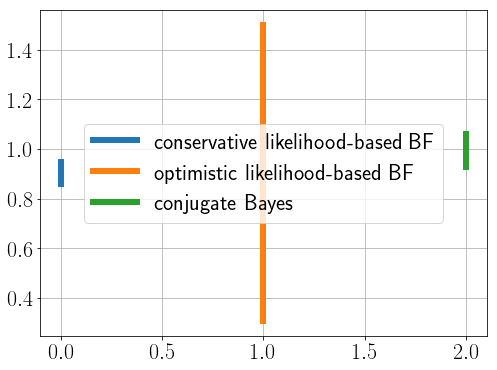

In [79]:
for k, res in enumerate(intervals.items()):
    method, interval = res
    plt.plot([k, k], [interval[0], interval[1]], label=method, linewidth=6)
    plt.grid()
    plt.legend()